In [7]:
import pandas as pd
import seaborn as sns
import os
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt

In [8]:
LOGS_FOLDER = "/mnt/c/Users/Diego/Documents/Università/alphazero_singleplayer/logs/RaceStrategy-v2/results"
DATA_FOLDER = "original_catalunya_20_cub"
directory = os.path.join(LOGS_FOLDER, DATA_FOLDER)
dfs = defaultdict(dict)
for entry in tqdm(os.scandir(directory)):
    if entry.is_file:
        filename = entry.name
        filename = filename[:-4]
        tokens = filename.split('_')
        timestamp = tokens.pop(0)
        df = pd.read_csv(entry.path)
        dfs[tokens[0] + "_" + timestamp][tokens[2]] = df
        dfs[tokens[0] + "_" + timestamp]['year'] = tokens[1]

80it [00:00, 241.13it/s]


In [9]:
database = pd.DataFrame(columns=['race', 'year', 'lap', 'driver', 'lap_time', 'cumulative_time', 'influence', 'position', 'id'])
index = 0
for race_id in tqdm(dfs):
    tokens = race_id.split('_')
    timestamp = tokens[1]
    race = tokens[0]
    year = dfs[race_id]['year']

    lap_times = dfs[race_id]['laptimes']
    influences = dfs[race_id]['lapinfluences']
    positions = dfs[race_id]['positions']
    race_times = dfs[race_id]['racetimes']
    
    columns = list(lap_times.columns)
    columns.remove('lap')

    for lap in lap_times.lap.unique():
        lap_time_single_lap = lap_times.loc[lap_times['lap'] == lap]
        influences_single_lap = influences.loc[influences['lap'] == lap]
        positions_single_lap = positions.loc[positions['lap'] == lap]
        race_times_single_lap = race_times.loc[race_times['lap'] == lap]
        for col in columns:
            index += 1
            new_df = {}
            new_df['id'] = [timestamp]
            new_df['race'] = [race]
            new_df['year'] = [year]
            new_df['lap'] = [lap]
            new_df['driver'] = [col]
            new_df['lap_time'] = lap_time_single_lap[col].values
            new_df['influence'] = influences_single_lap[col].values
            new_df['cumulative_time'] = race_times_single_lap[col].values
            new_df['position'] = positions_single_lap[col].values
            new_df = pd.DataFrame(new_df, index=[index])
            database = pd.concat([database, new_df])


database.describe()


100%|██████████| 20/20 [02:15<00:00,  6.77s/it]


,lap_time,cumulative_time
count,21861.000000,21861.000000
mean,90.980104,2932.367151
std,6.227184,1712.490943
min,81.065000,93.023000
25%,87.937000,1450.180000
50%,89.463000,2910.074000
75%,91.318000,4437.790000
max,130.769000,5943.778000


In [10]:
database

,race,year,lap,driver,lap_time,cumulative_time,influence,position,id
1,Catalunya,2017,1,VAN,101.974,101.974,none,19,1602750323919
2,Catalunya,2017,1,RIC,97.574,97.574,none,8,1602750323919
3,Catalunya,2017,1,VET,94.843,94.843,none,3,1602750323919
4,Catalunya,2017,1,RAI,NaN,NaN,retiring,20,1602750323919
5,Catalunya,2017,1,GRO,97.974,97.974,none,9,1602750323919
...,...,...,...,...,...,...,...,...,...
26396,Catalunya,2017,66,VER,NaN,NaN,none,19,1602750331305
26397,Catalunya,2017,66,HAM,83.884,5835.108,none,1,1602750331305
26398,Catalunya,2017,66,SAI,NaN,NaN,none,3,1602750331305
26399,Catalunya,2017,66,BOT,NaN,NaN,none,17,1602750331305


<AxesSubplot:xlabel='lap', ylabel='lap_time'>

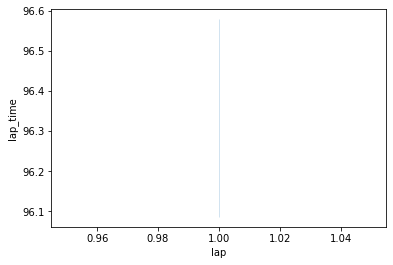

In [13]:
vettel = database.loc[(database['driver'] == 'RIC') & (database['race'] == 'Catalunya')]
vettel = vettel.sort_values('lap')
pits = []
for index, row in vettel.iterrows():
    if 'pitinlap' in row['influence']:
        pits.append(row['lap'])
sns.lineplot(data=vettel, y='lap_time', x='lap')
#plt.ylim([85, 95])

In [14]:
len(pits)/len(vettel['id'].unique())

2.0

In [7]:
vettel['position'] = vettel['position'].astype(int)
vettel['cumulative_time'] = vettel['cumulative_time'].astype(int)
vettel[vettel['lap'] == vettel['lap'].max()].describe()

,lap_time,cumulative_time,position
count,20.000000,20.000000,20.0
mean,87.194800,5927.900000,2.0
std,0.458159,4.854732,0.0
min,86.043000,5917.000000,2.0
25%,86.886250,5924.750000,2.0
50%,87.267000,5928.500000,2.0
75%,87.606500,5931.250000,2.0
max,87.694000,5935.000000,2.0


In [40]:
vettel['position'] = vettel['position'].astype(int)
vettel['cumulative_time'] = vettel['cumulative_time'].astype(int)
vettel[vettel['lap'] == vettel['lap'].max()].describe()

,lap_time,cumulative_time,position
count,20.000000,20.000000,20.000000
mean,86.300050,5889.150000,1.950000
std,0.485724,5.499043,0.223607
min,85.593000,5880.000000,1.000000
25%,85.878750,5883.000000,2.000000
50%,86.273500,5890.500000,2.000000
75%,86.724750,5893.250000,2.000000
max,87.166000,5897.000000,2.000000


In [16]:
import numpy as np
import matplotlib.pyplot as plt
online_scores = np.load('../data/2020-10-14_18-21/game/trpo_2_32_0.001/models/2020-10-14_18-21/online_scores.npy')
offline_scores = np.load('../data/2020-10-14_18-21/game/trpo_2_32_0.001/models/2020-10-14_18-21/offline_scores.npy', allow_pickle=True)
print(offline_scores)

[list([7.89640374307387, 0.0]) 3.08 3.02 3.34 0.0
 list([12.57562964395507, 0.0]) 17.92 1.72 21.98 0.0
 list([12.998051882745498, 0.0]) 23.64 1.08 20.86 0.0
 list([13.195839795640815, 0.0]) 17.04 1.02 27.82 0.0
 list([13.216797443994983, 0.0]) 14.54 1.08 29.9 0.0]


<AxesSubplot:>

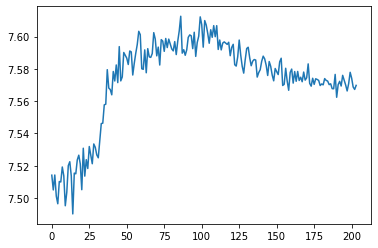

In [13]:
sns.lineplot(data=online_scores)

In [11]:
sns.lineplot(data=online_scores[:, 0])
plt.title("Return per epoch")

import numpy as np

lower_bound = online_scores[:, 0] - online_scores[:, 1]
upper_bound = online_scores[:, 0] + online_scores[:, 1]

plt.fill_between(np.arange(200) , lower_bound, upper_bound, alpha=.3)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed